<h1> Exploracion de los Datos (EDA) </h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_parquet('../data/processed/online_retail_II_cleaned.parquet')

In [2]:
# Confiuracion inicial para graficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Verificacion Inicial de los Datos

### Veficiacion Tipos de Datos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386732 entries, 0 to 386731
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoice      386732 non-null  string        
 1   stockcode    386732 non-null  string        
 2   description  386732 non-null  string        
 3   quantity     386732 non-null  int16         
 4   invoicedate  386732 non-null  datetime64[ns]
 5   price        386732 non-null  float32       
 6   customer_id  386732 non-null  Int32         
 7   country      386732 non-null  string        
dtypes: Int32(1), datetime64[ns](1), float32(1), int16(1), string(4)
memory usage: 18.8 MB


### Verificacion de valores negativos o iguales a cero en las variables '`quantity`' y '`price`'

In [4]:
print(f"Cantidades con valores iguales o menores a cero: {(df['quantity'] <= 0).sum()}")
print(f"Precios con valores iguales o menores a cero: {(df['price'] <= 0).sum()}")

Cantidades con valores iguales o menores a cero: 0
Precios con valores iguales o menores a cero: 0


### Estadistica Descriptiva de las Variables '`quantity`' y '`price`'

In [5]:
df[['quantity', 'price']].describe()

,quantity,price
count,386732.000000,386732.000000
mean,13.864767,3.312451
std,98.973734,35.643150
min,1.000000,0.001000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,19152.000000,10953.500000


En la variable *`quantity`*, la mediana es de **5**, mientras que el promedio es de **13.77**, lo que indica que la mayoría de las transacciones involucran pocas unidades, pero existen compras excepcionalmente grandes que elevan la media. Esto se refuerza con un valor máximo de **19,152** y una desviación estándar elevada (**97.64**), evidenciando una alta dispersión y una distribución sesgada a la derecha.

Para la variable *`price`*, la mediana es de **1.95** y el promedio alcanza **3.31**, lo que sugiere que la mayoría de los productos tienen precios bajos, aunque existen artículos con precios extremadamente altos. El valor máximo de **10,953.5** y la desviación estándar de **35.02** confirman una alta variabilidad y la presencia de outliers.

### Verificacion de Fechas y Clientes unicos

In [6]:
print(f"Rango de Fechas: {df['invoicedate'].dt.date.min()} a {df['invoicedate'].dt.date.max()}")
print(f"Total Clientes Únicos: {df['customer_id'].nunique()}")

Rango de Fechas: 2009-12-01 a 2010-11-30
Total Clientes Únicos: 4266


Se valida que el dataset sea temporalmente suficiente y estadísticamente adecuado para estimar el CLTV en un horizonte de 6 meses. Ademas se verifica el tamaño de clientes unicos en todo el dataset y para el periodo de entrenamiento.

## Creacion de Variable Monetaria

In [7]:
df['total_spend'] = df['quantity'] * df['price']
df.head()

,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country,total_spend
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.399994
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.000000
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.000000
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.799995
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.000000


Calcular el monto monetario de cada transacción, que será la base para estimar el valor económico del cliente en el modelo de CLTV a 6 meses.

- Permite medir cuánto gasta cada cliente en cada compra.
- Facilita la agregación posterior a nivel cliente (gasto promedio, gasto total).

### Validaciones de la Variable Monetaria

In [8]:
print((df['total_spend'] > 0).sum())

386732


Se valida que la variable monetaria no contenga valores negativos, ya que esto podría distorsionar los cálculos de CLTV. El resultado indica que todos los valores son positivos, lo cual es adecuado para el análisis.

### Resumen estadístico de la Variable Monetaria

In [9]:
df['total_spend'].describe()

count    386732.000000
mean         21.946918
std          77.236229
min           0.001000
25%           5.000000
50%          12.500000
75%          19.500000
max       15818.400391
Name: total_spend, dtype: float64

En la estadistica descriptiva de la variable monetaria (*`total_spend`*), se observa que el promedio de gasto por transaccion es de aproximadamente **21.9**, con una mediana de **12.5**, lo que indica que la mayoria de las transacciones son de montos relativamente bajos. Sin embargo, el valor maximo alcanza los **15818.4**, lo que sugiere la presencia de algunas transacciones excepcionalmente altas que pueden influir en el promedio. La desviacion estandar es bastante alta (**77.2**), lo que refuerza la idea de una gran variabilidad en los montos gastados por los clientes, indicando a la vez una distribucion sesgada hacia la derecha.

## Cálculo de métricas RFM a nivel cliente

In [10]:
# Fecha de referencia (el día siguiente a la última compra del dataset)
snapshot_date = df['invoicedate'].max() + pd.to_timedelta(1, unit='D')

# Agregación por Cliente (RFM)
rfm = df.groupby('customer_id').agg({
    'invoicedate': lambda x: (snapshot_date - x.max()).days, # Recencia
    'invoice': 'nunique',                                    # Frecuencia
    'total_spend': 'sum'                                     # Valor Monetario
}).rename(columns={
    'invoicedate': 'Recency',
    'invoice': 'Frequency',
    'total_spend': 'Monetary'
})

rfm.head()


,Recency,Frequency,Monetary
customer_id,,,
12346,156,11,372.859985
12347,31,1,611.530029
12348,65,1,222.160019
12349,34,3,2671.139893
12351,2,1,300.929993


Se obtienen las fechas de ultima compra, frecuencia de compras y monto monetario total por cliente, que son fundamentales para segmentar a los clientes y predecir su valor futuro.

De esta manera, se crea el DataFrame `rfm` que contiene las métricas RFM (Recencia, Frecuencia y Valor Monetario) para cada cliente, lo cual es esencial para el análisis de CLTV.

- **Recencia**: Días desde la última compra hasta la fecha de referencia (snapshot_date).
- **Frecuencia**: Número de compras únicas realizadas por el cliente.
- **Valor Monetario**: Suma total gastada por el cliente.

### Graficas de Distribucion de las Metricas RFM

#### Distribución de Recencia

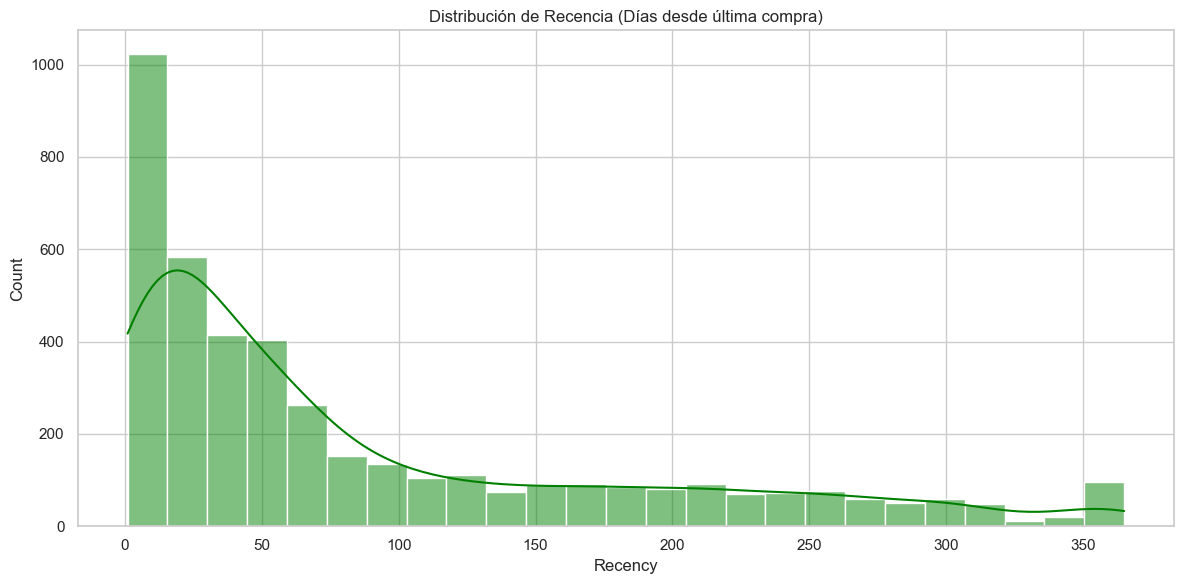

In [11]:
sns.histplot(rfm['Recency'], kde=True, color='green')
plt.title('Distribución de Recencia (Días desde última compra)')
plt.tight_layout()
plt.show()

Churn (tasa de abandono): fenómeno en el que un cliente deja de interactuar o comprar en el negocio.

En la distribución de la recencia se observa una alta concentración de clientes con recencias bajas en el rango de 0 a 50 días, lo que indica que una parte importante del mercado está activa recientemente. A su vez, se aprecia una cola larga hacia la derecha que representa clientes inactivos o en churn. Esta forma sesgada es la esperada en datos de comportamiento de compra y confirma que la recencia está correctamente calculada.

#### Distribución de Frecuencia

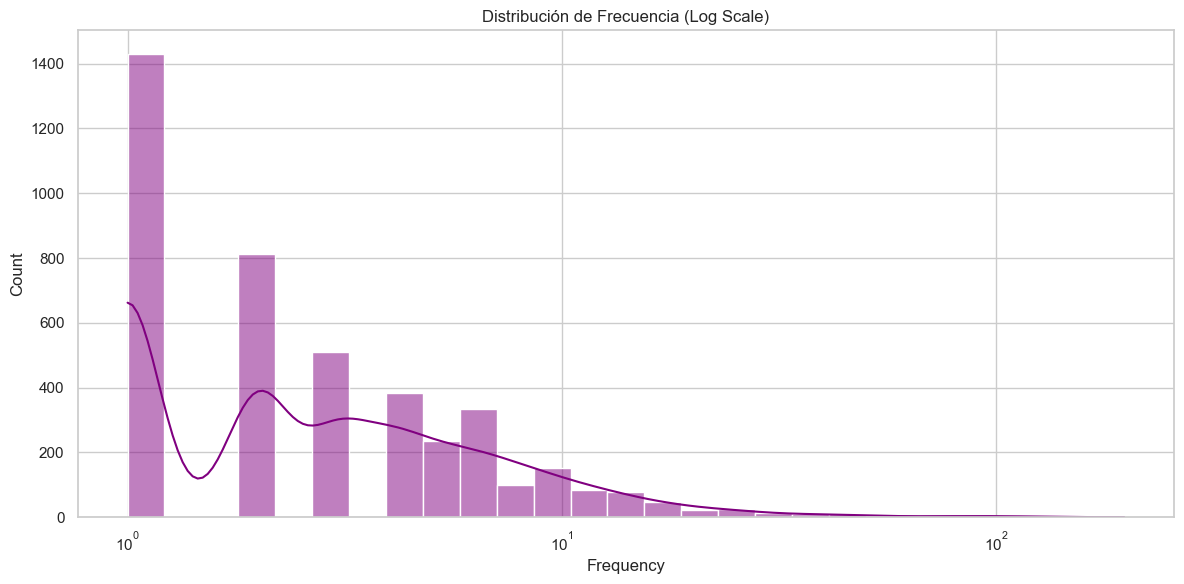

In [12]:
sns.histplot(rfm['Frequency'], kde=True, log_scale=True, color='purple')
plt.title('Distribución de Frecuencia (Log Scale)')
plt.tight_layout()
plt.show()


La distribución de la frecuencia muestra que la mayoría de los clientes realizan pocas compras, con una concentración significativa en el rango de 1 a 5 compras. Esto indica que muchos clientes son compradores ocasionales. Sin embargo, también se observa una cola larga hacia la derecha, lo que sugiere que hay un grupo más pequeño de clientes que son altamente activos y realizan numerosas compras. Esta distribución sesgada es típica en datos de comportamiento de compra. 

**Nota tecnica**: Los espacios entre las barras, ocurren debido al efecto del logaritmo, este agranda los rangos entre los valores pequeños y comprime los de los valores grandes.

#### Distribución de Valor Monetario

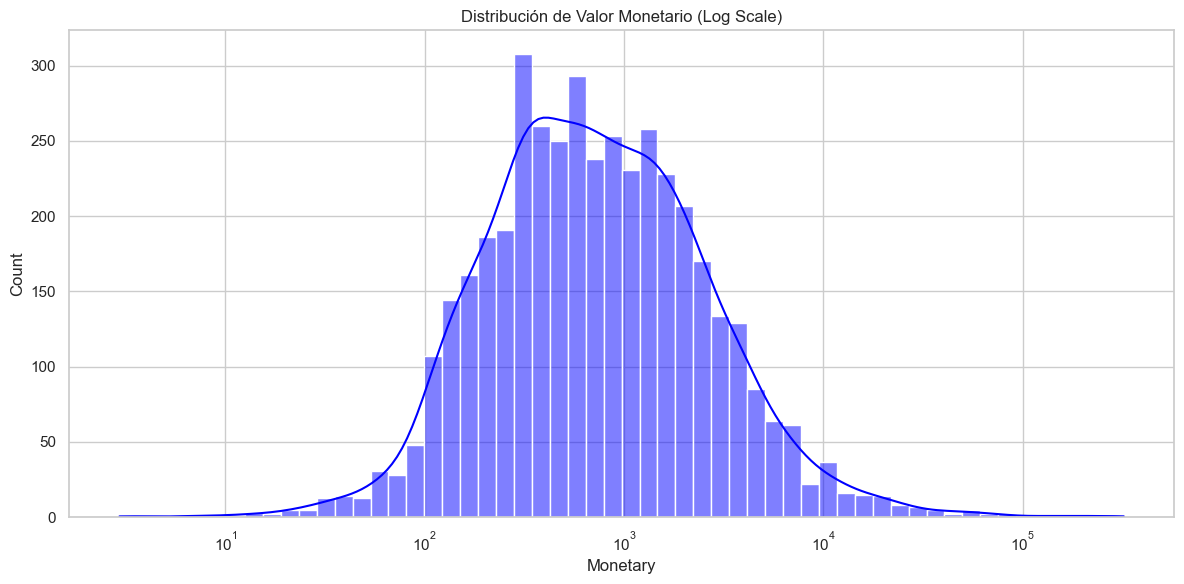

In [13]:
sns.histplot(rfm['Monetary'], kde=True, log_scale=True, color='blue')
plt.title('Distribución de Valor Monetario (Log Scale)')
plt.tight_layout()
plt.show()


En la distribución del valor monetario, se observa una distribución en forma de campana, en la que la mayoría de los clientes concentran su gasto entre $10^2$ (100) y $10^3$ (1,000) unidades monetarias. Esta simetría, lograda gracias a la transformación logarítmica, permite identificar con claridad el gasto promedio de la base de clientes y facilita la distinción entre clientes de bajo valor y clientes de alto impacto (outliers de alto gasto) situados en el extremo derecho de la distribución

#### Distribución de Valor Monetario (sin log scale)

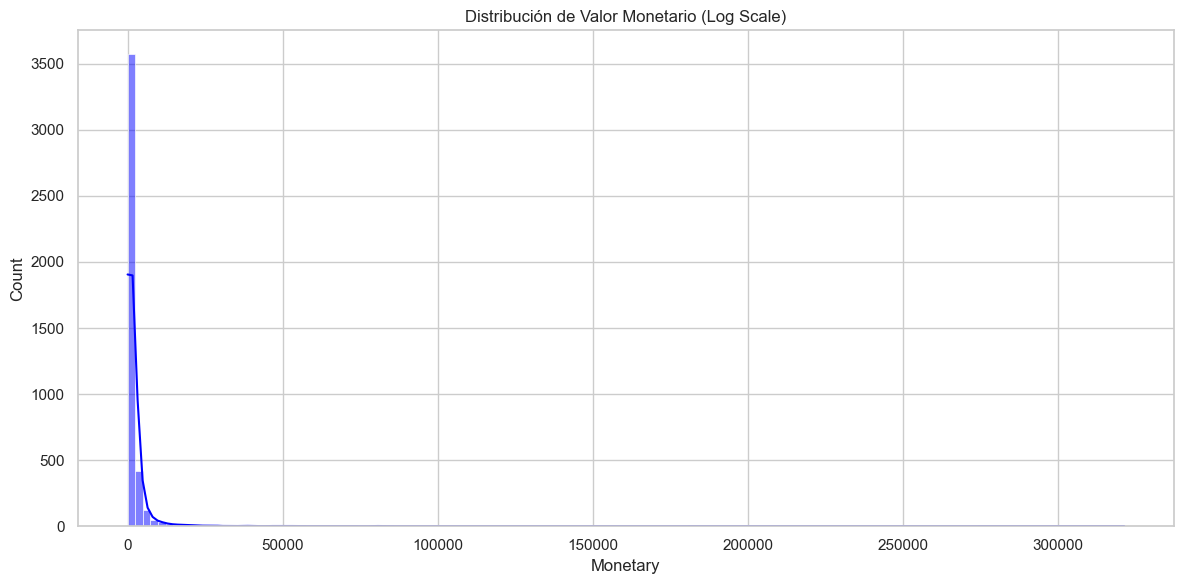

In [14]:
sns.histplot(rfm['Monetary'], kde=True, color='blue')
plt.title('Distribución de Valor Monetario (Log Scale)')
plt.tight_layout()
plt.show()

La grafica sobre la distribución del valor monetario sin escala logarítmica revela una fuerte heterogeneidad en el gasto total de los clientes, con una cola larga hacia la derecha. Esto indica que hay una minoria de clientes que gastan cantidades significativamente mayores que el resto, haciendo que la distribución sea asimétrica. Este comportamiento es totalmente real y esperado de acuerdo al origen de los datos, es necesario utilizar un modelo que pueda capturar esta heterogeneidad para estimar el CLTV de manera precisa.

## Curva de Concentración de Valor (Análisis de Pareto 80/20)

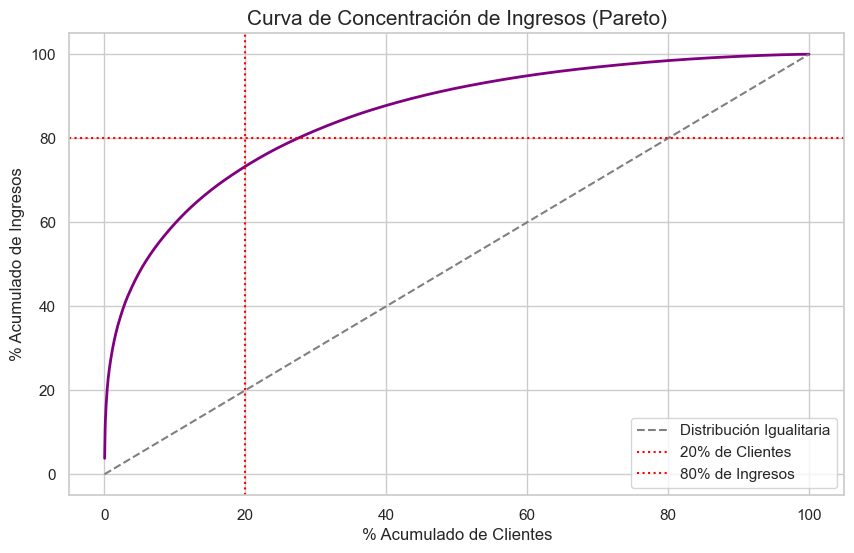

In [15]:
# Ordenar clientes por gasto de mayor a menor
rfm_sorted = rfm.sort_values(by='Monetary', ascending=False)

# Calcular porcentajes acumulados
rfm_sorted['Cum_Revenue'] = rfm_sorted['Monetary'].cumsum()
rfm_sorted['Cum_Rev_Perc'] = 100 * rfm_sorted['Cum_Revenue'] / rfm_sorted['Monetary'].sum()
rfm_sorted['Cum_Customers_Perc'] = 100 * (np.arange(len(rfm_sorted)) + 1) / len(rfm_sorted)

# Gráfico de Lorenz
plt.figure(figsize=(10, 6))
plt.plot(rfm_sorted['Cum_Customers_Perc'], rfm_sorted['Cum_Rev_Perc'], color='purple', lw=2)
plt.plot([0, 100], [0, 100], color='gray', linestyle='--', label='Distribución Igualitaria')
plt.axvline(x=20, color='red', linestyle=':', label='20% de Clientes')
plt.axhline(y=80, color='red', linestyle=':', label='80% de Ingresos')

plt.title('Curva de Concentración de Ingresos (Pareto)', fontsize=15)
plt.xlabel('% Acumulado de Clientes')
plt.ylabel('% Acumulado de Ingresos')
plt.legend()
plt.show()

Principio de Pareto: Es una tecnica que sugiere que aproximadamente el 80% de los efectos provienen del 20% de las causas. En el contexto de clientes y ventas, esto significa que una pequeña proporción de clientes suele generar la mayor parte de los ingresos.

En el Grafico se observa la curva de concentracion de los ingresos, donde el 20% de los clientes generan aproximadamente el 75% de los ingresos totales. Esto confirma el principio de Pareto, indicando que una minoría de clientes es responsable de la mayor parte del valor monetario. Esta informacion es crucial para estrategias de marketing y retencion, ya que permite identificar y enfocarse en los clientes mas valiosos para maximizar los ingresos. 

**Nota tecnica**: Si bien este gráfico no es un input directo para el algoritmo predictivo de CLTV, constituye una validación exploratoria fundamental. Confirma la heterogeneidad de la base de datos y justifica la necesidad de utilizar modelos avanzados (como redes neuronales) para capturar patrones de comportamiento complejos que un simple promedio no revelaría.

## Análisis de Estacionalidad y Tendencia de Ingresos

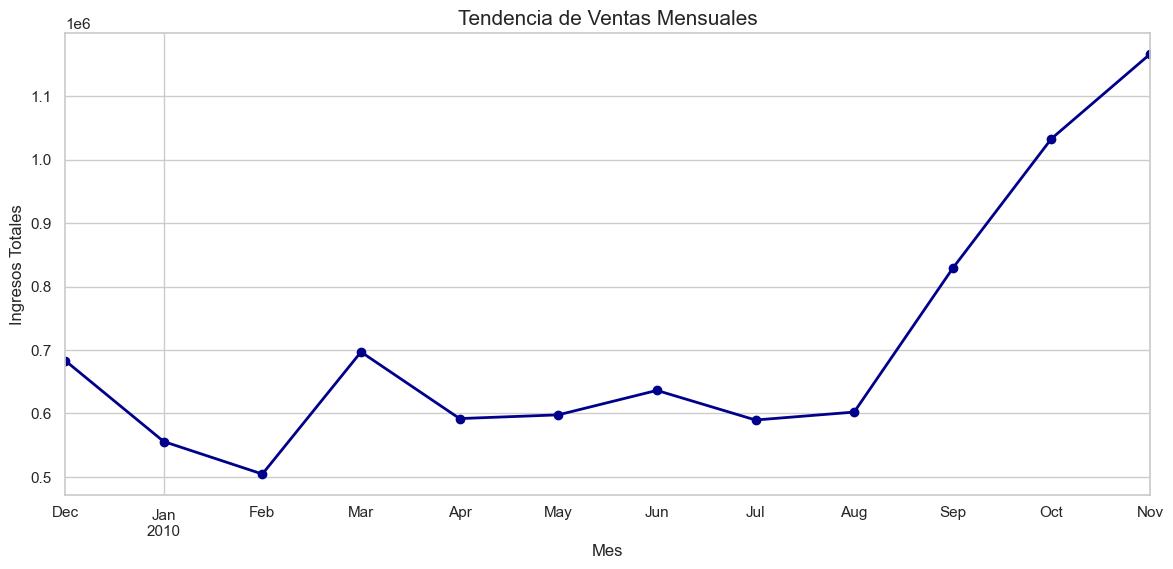

In [16]:
# Agrupar por mes
df['month_year'] = df['invoicedate'].dt.to_period('M')
monthly_sales = df.groupby('month_year')['total_spend'].sum()

# Gráfico de Línea
plt.figure(figsize=(14, 6))
monthly_sales.plot(marker='o', color='darkblue', linewidth=2)
plt.title('Tendencia de Ventas Mensuales', fontsize=15)
plt.xlabel('Mes')
plt.ylabel('Ingresos Totales')
plt.grid(True)
plt.show()

En el gráfico se observa la evolución temporal de los ingresos totales a lo largo de un periodo de 13 meses (de diciembre a diciembre). Durante el primer semestre del año 2010, se observa una subida de los ingresos de febrero a marzo, seguida de una meseta relativamente estable de abril a agosto, con ingresos fluctuando alrededor de los 0.6 millones sin picos significativos.

A partir de septiembre, se evidencia un cambio drástico en la tendencia, marcando el inicio de un crecimiento acelerado que culmina en un pico máximo en noviembre, superando los 1.1 millones en ingresos. Este comportamiento sugiere una fuerte estacionalidad asociada al periodo de fin de año (posiblemente campañas de Black Friday o compras navideñas anticipadas).


## Distribución de la Densidad de Recompra (Tiempo entre compras)

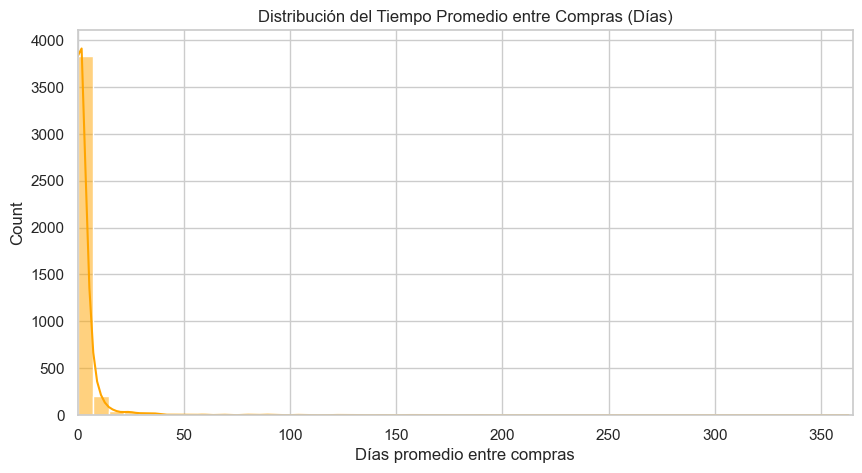

Mediana de días entre compras: 1.0816326530612246 días


In [19]:
# Calcular diferencia entre compras para cada cliente
df_sorted = df.sort_values(['customer_id', 'invoicedate'])
df_sorted['prev_date'] = df_sorted.groupby('customer_id')['invoicedate'].shift(1)
df_sorted['days_diff'] = (df_sorted['invoicedate'] - df_sorted['prev_date']).dt.days

# Promedio de días entre compras por cliente (solo para quienes compraron > 1 vez)
avg_days_between = df_sorted.groupby('customer_id')['days_diff'].mean().dropna()

plt.figure(figsize=(10, 5))
sns.histplot(avg_days_between, bins=50, kde=True, color='orange')
plt.title('Distribución del Tiempo Promedio entre Compras (Días)')
plt.xlabel('Días promedio entre compras')
plt.xlim(0, 365) # Limitamos a un año para ver mejor
plt.show()

print(f"Mediana de días entre compras: {avg_days_between.median()} días")

C:\Users\DesktopLaptopGoD\AppData\Local\Temp\ipykernel_17836\2427620718.py:13: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 365) # Limitamos a un año para ver mejor


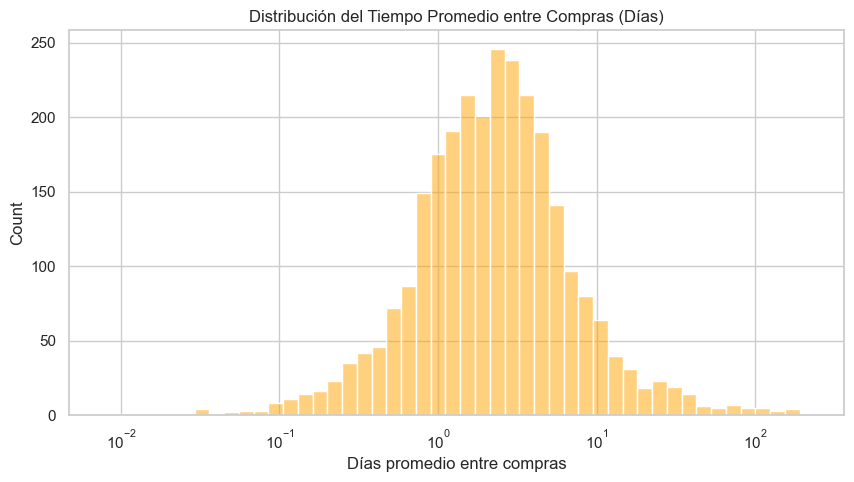

Mediana de días entre compras: 1.0816326530612246 días


In [17]:
# Calcular diferencia entre compras para cada cliente
df_sorted = df.sort_values(['customer_id', 'invoicedate'])
df_sorted['prev_date'] = df_sorted.groupby('customer_id')['invoicedate'].shift(1)
df_sorted['days_diff'] = (df_sorted['invoicedate'] - df_sorted['prev_date']).dt.days

# Promedio de días entre compras por cliente (solo para quienes compraron > 1 vez)
avg_days_between = df_sorted.groupby('customer_id')['days_diff'].mean().dropna()

plt.figure(figsize=(10, 5))
sns.histplot(avg_days_between, bins=50, log_scale=True, kde=True, color='orange')
plt.title('Distribución del Tiempo Promedio entre Compras (Días)')
plt.xlabel('Días promedio entre compras')
plt.xlim(0, 365) # Limitamos a un año para ver mejor
plt.show()

print(f"Mediana de días entre compras: {avg_days_between.median()} días")

En el grafico se observa la distribucion de tiempo entre compras (dias que transcurren entre una compra y la siguiente) en una escala logaritmica. La forma resultante se aproxima a una distribución log-normal, lo que indica que, aunque la mayoría de los clientes se concentra en un rango específico, existe una variabilidad significativa hacia los extremos.

- El pico de la distribución (moda) se sitúa en el intervalo comprendido entre 2 y 5 días aproximadamente. Esto sugiere que el segmento más representativo de clientes recurrentes tiende a realizar transacciones con una alta frecuencia, reabasteciéndose o comprando nuevos ítems en lapsos muy cortos tras su última adquisición.
- Se aprecian registros por debajo de $10^0$ (1 día), lo que corresponde a clientes que realizan múltiples pedidos dentro del mismo día, reflejando un comportamiento de compra intensivo en ciertos casos.  
- Finalmente, se detecta una cola que se extiende hacia los $10^2$ (100 días), representando a clientes esporádicos con ciclos de recompra trimestrales.

El uso de la escala logarítmica en el eje X es crucial para la visualización, ya que el dataset sin escala logaritmica presenta un sesgo positivo. Para el modelado de redes neuronales, esta variable es un predictor potente del Churn.

## Matriz de Correlación de Pearson para Variables RFM

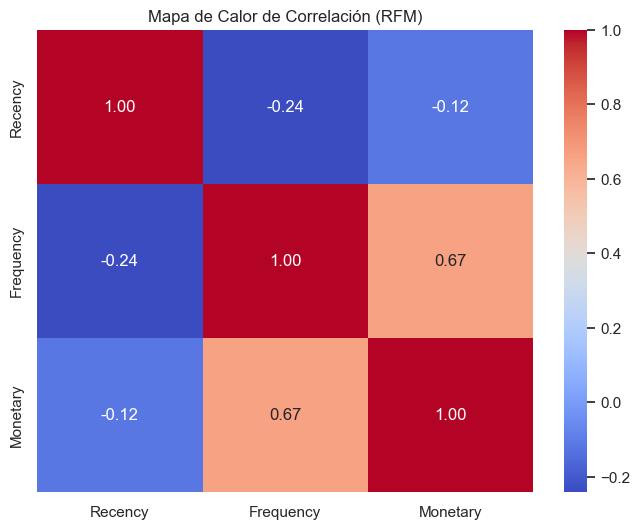

In [18]:
# Matriz de correlación simple sobre la tabla RFM
plt.figure(figsize=(8, 6))
sns.heatmap(rfm.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de Correlación (RFM)')
plt.show()

En el mapa de calor se evidencia una correlación positiva significativa (0.67) entre las variables Frequency y Monetary. Este coeficiente indica una fuerte asociación lineal: los clientes que realizan transacciones con mayor frecuencia tienden a acumular un mayor valor monetario total. Este hallazgo es consistente con la lógica de negocio, donde la recurrencia es un impulsor directo del Customer Lifetime Value (CLTV).

El signo negativo en las correlaciones con Recency es el comportamiento esperado y deseable. Dado que un valor menor de recencia es mejor (indica una compra más reciente), es lógico que se correlacione inversamente con la Frecuencia y el Monto (donde valores mayores son mejores). Es decir, los clientes "más recientes" (menor valor numérico en días) tienden a ser los más frecuentes y los que más gastan.

## Conclusiones de la Exploración de Datos

Tras la inspección estadística y visual del conjunto de datos, se destacan los siguientes hallazgos clave que fundamentan la estrategia de modelado posterior:

- Concentración del Valor (Pareto): Se confirmó que una minoría de clientes (aprox. el 20%) genera la gran mayoría de los ingresos (aprox. 75%). Esto valida la necesidad de un modelo predictivo capaz de segmentar con precisión a estos clientes de alto valor para optimizar recursos de retención.

- Integridad Temporal y Estacionalidad: Se identificó una marcada estacionalidad con picos de venta hacia el cierre del año. Asimismo, se depuró la serie temporal eliminando el mes de diciembre de 2010 por inconsistencia en la recolección de datos, garantizando así que el entrenamiento del modelo no se vea afectado por sesgos de información incompleta.

- Relación entre Variables (RFM): El análisis de correlación evidenció una fuerte asociación positiva entre la Frecuencia de compra y el Valor Monetario, confirmando que ambas métricas son predictores robustos y complementarios. No se detectó multicolinealidad crítica que impida su uso conjunto.
Patrones de Comportamiento: La distribución del tiempo entre compras sugiere patrones log-normales, donde las desviaciones respecto al promedio individual de cada cliente pueden servir como señales tempranas de churn (abandono).

Siguiente Paso: Con base en estos insights y habiendo validado la calidad de los datos, se procede a la fase de Ingeniería de Características (Feature Engineering) para transformar estas variables transaccionales en inputs adecuados para la red neuronal.